# Introduction

People have their respective traits and looks by which we can recognize who they are; what if we took all of it away and were left only with their messages? Would we be able to recognize them? Would AI be able to recognize them?

Answering this question, I will create an ML pipeline for classifying the sender of a message based on other messages they sent. I will also compare the results with humans to see if the signal is strong enough for at least humans to recognize each other.

# Data

## Dataset

The dataset used in this assignment is a collection of all the messages from one of the group chats, where I and 4 of my friends exchange messages. The group chat was created during the quarantine in Seoul, South Korea, in early February 2022 and has been used until now.

### What is in the dataset?

Messages from the five people in the context of this group. Messages related to everyday life, funny situations, planning trips or outings together. 

### What does the dataset not include?

Any form of text or written communication is not in this group chat's context. What I mean by this is that people have different writing styles in different contexts. For example, an email will have a different format, tone, word choice, etc. The same goes for different people. For instance, in the same context of telegram direct messages, I would formulate my messages differently based on who is on the receiving end due to differences in communication goals and relationship with the person. Therefore, I want to emphasize that this dataset includes only texts from the context of the group chat with those specific people.

## Data Generation

Data was generated by texting the group chat without any prior knowledge that one might use it as a dataset for a machine learning project, so there should be no substantial problems with any biases.

## Data Gathering

The `telethon` package was used to gather and save all the data to the JSON file. The names of the people were removed, and IDs were used instead to identify them. The study has three main components of interest: texts (text content of the message), timestamps for the message, and sender's ID. The model will make predictions solely from the text content of the message and features that will be engineered before training the model.

```json
{
    "id": 133146,
    "text": "Just ran up my leg",
    "from": 483161515,
    "timestamp": 1706106108.0
}
```

# Converting to Data readable Python

In this case, it is pretty simple as we can use `json` module to load data to a dictionary, which can be directly used to create a `Pandas` `DataFrame`. I use `DataFrame` as it allows for easier data manipulation in the pre-processing step compared to a `np.array`, but both can be used.

In [3]:
import json
import pandas as pd

# Open file with data
with open('data.json', 'r') as f:
    # Read data with json module
    data = json.load(f)

# Create a dataframe based on the data
df = pd.DataFrame(data)

# Print the first 5 examples
df.head()

,id,text,from
0,133146,Just ran up my leg,483161515
1,133145,It was,483161515
2,133144,Hahahah,483161515
3,133143,aggressive much?,1798750378
4,133142,omg,1798750378


# Pre-processing

## Cleaning Up

We should clean up the data to make training the model easier and more efficient.

### Remove Links

It is often the case that someone would send a link to a TikTok video or Airbnb. Those links, while they might indicate who the author of the message is, are not intended to be used for classification. 

### Non-alphanumerical Characters

At some point, we want to vectorize the data so that it is in a readable format for the model. Punctuation signs and non-alphanumerical characters would create additional tokens and unnecessary complexities for this classification.

### Transform all Words to Lowercase

Like the previous point, the model with limited data would have hardships recognizing the differences between the lowercase and uppercase tokens, so I will transform all words to lowercase.

### Remove stopwords

In english there are multiple words that do not convey any meaning. For example, 'a', 'about', 'your', 'an', 'because', etc. We remove those words to further simplify the model.

### Target Classes

Currently, the target classes are the IDs from Telegram; however, to simplify the analysis further, I will change them to numbers from 0 to 4.

### Messages with 0 length

Telegram can send messages other than simple text, in which case the message content is empty. Messages with a length of 0 will be removed from the dataset to prevent situations in which the message's content is empty. 

### Lemmatization

Words can have different forms. For example, one might say "he likes swimming" or "I like to swim." Both have similar meanings, yet would be represented as two different tokens with the vectorizer. To prevent that we use the lemmatization, which reduces different words to their base form. 

## Feature Engineering

After playing a game of guessing who said what, I found some features that might help the model recognize the people better.

### Starts with a Capital Letter

Some people start their messages with capital letters, which can be a good indicator of whether or not the message comes from that group of people.

### Number of Punctuation Signs

Again, some people like their exclamation marks while others do not, so having information about the number of punctuation signs can be helpful.

### Use of Numbers

In the group chat, we have different majors—some like to quantify their claims while others don't, so the number of digits in a text can be another good indicator.

In [4]:
# some messages have a different type than text
# for example files, geo locations, videos, etc,
# we do not include them in the analysis;
# thus, we drop them here
df.dropna(inplace=True)

# Get rid of any unnecessary whitespaces
df['text'] = df['text'].map(lambda x: x.strip())

# Drop any links as we do not want the model
# to learn based on links, but rather actual
# messages
df = df[
    [("http" not in s) and ("tg://" not in s) and bool(s) for s in df["text"]]
]

In [5]:
import string

# add a feature to the dataset
df['starts_with_capital'] = df['text'].map(lambda s: 1 if s[0].isupper() else 0)
# add another feature counting the number of numbers in the text
df['number_count'] = df['text'].map(lambda s: sum([1 if ch.isnumeric() else 0 for ch in s]))
# count the number of punctuations signs in a string
df['punctuation_count'] = df['text'].map(lambda s: sum([1 if ch in string.punctuation else 0 for ch in s]))

additional_features = ['starts_with_capital', 'number_count', 'punctuation_count']

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stp_wrds = set(stopwords.words("english"))
wnl = WordNetLemmatizer()

# remove all non-alphanumeric characters and non-spaces
df["text"] = df["text"].map(
    lambda s: "".join(filter(lambda x: x.isalnum() or x.isspace(), s))
)

# remove the common stopwords
df["text"] = df["text"].map(lambda s: ' '.join(filter(lambda w: w in stp_wrds, s.split())))

# send all characters to lower
df["text"] = df["text"].map(lambda x: x.lower())

# lemmatize using wordnet
df["text"] = df["text"].map(lambda x: wnl.lemmatize(x))

# Drop messages with less than 5 words
# We need to give our model something to work with
df = df[[len(s.split()) > 0 for s in df["text"]]]

# Transforms the labels from telegram ids to simple
# numbers from 0 to 5
labels = df["from"]
lton = {l: i for i, l in enumerate(set(labels))}
df["from"] = df["from"].map(lton)

In [7]:
df.head()

,id,text,from,starts_with_capital,number_count,punctuation_count
0,133146,up my,1,1,0,0
1,133145,wa,1,1,0,0
9,127647,is a,1,1,0,0
14,122273,do it,1,1,0,0
15,122272,or,0,0,1,0


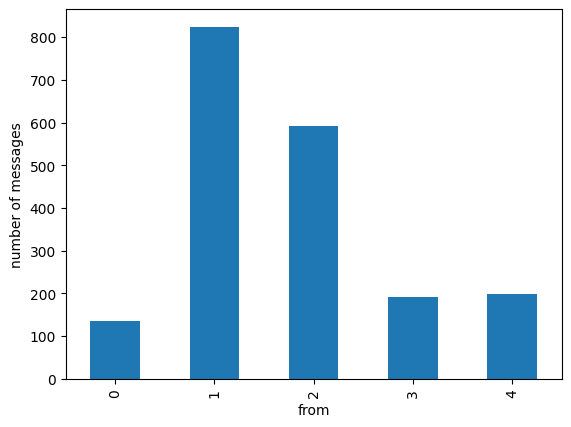

In [8]:
import matplotlib.pyplot as plt

cls_to_name = {0: "Krystian", 1: "Tim", 2: "Alina", 3: "Mashiko", 4: "Mira"}

df.groupby("from").count()["text"].plot(kind="bar")
plt.ylabel("number of messages")
plt.show()

## Balancing Dataset

As shown in the bar plot above, the dataset is imbalanced. For the model to learn something more than the fact that half of the messages come from a single person, the dataset should be balanced.

Multiple methods can be used to deal with this problem, including gathering more data, oversampling, or undersampling. Gathering more data would be complex because I would need to make people text more or find another group chat with the same people but with a better distribution of texts. Oversampling would consist of sampling from the underrepresented classes more than from the others, but this would also require data augmentation, which might lose some information pertaining to the specifics of the tone and word choices of people. Therefore, the undersampling will be used. Random samples from the overrepresented labels will be chosen and deleted.

In [9]:
from collections import Counter
import numpy as np

# limit the number per class to n
n = min(Counter(df["from"].values).values())

for cls in set(df["from"]):
    ids = df[df["from"] == cls].id.values
    n_to_drop = len(ids) - n
    if n_to_drop > 0:
        ids_to_drop = np.random.choice(ids, size=n_to_drop, replace=False)
        df = df[~df["id"].isin(ids_to_drop)]

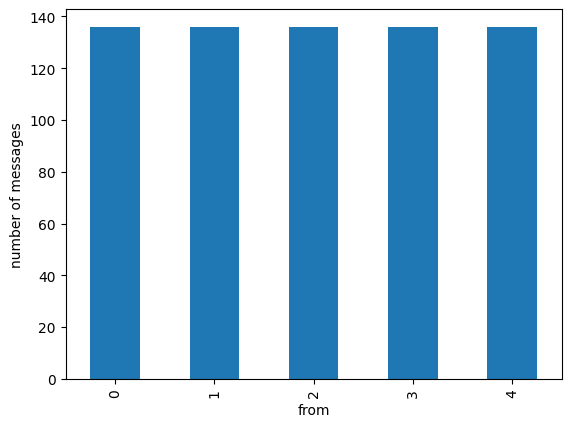

In [10]:
df.groupby("from").count()["text"].plot(kind="bar")
plt.ylabel("number of messages")
plt.show()

In [11]:
# Print 10 random samples
df[df['id'].isin(np.random.choice(df['id'].values, 10, replace=False))]

,id,text,from,starts_with_capital,number_count,punctuation_count
507,109993,can you an,1,1,0,0
707,105915,was in for a few i there,2,0,0,1
964,94410,was he,4,1,0,1
994,93996,now if,1,1,0,0
1037,90031,but a very,3,0,0,1
1130,67742,when will,4,1,2,2
1258,56647,its all over again,0,0,0,0
2230,37685,i for to be,3,0,0,0
2765,33472,for me,1,1,0,0
3305,25597,my to our so that i up,2,0,0,2


Now, there are more features in the dataset and the texts are formatted in a way easier to read by the model.

# Task

## Description

I want to know if the model will be able to recognize the sender of a message based on the message and the feature engineered in the pre-processing step.

Features: 
- text: the content of the message
- starts_with_capital: whether or not the message starts with a capital letter
- number_count: number of digits in the message
- punctuation_count: number of punctuation signs in the message

Dependent Variable:
- from: number from 0 to 4 signifying who sent the message

## Train-test split

We are going to split data into the training and testing splits. I decided to make a 85-15 split, because the data is quite limited. We are going to shuffle data to ensure randomization to prevent any biases related to when the message was sent.

In [12]:
from sklearn.model_selection import train_test_split

X_data, y_data = df[['text'] + additional_features].values, df['from'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, shuffle=True)

In [13]:
X_train[:5], y_train[:5]

(array([['are we to', 0, 0, 0],
        ['but', 0, 0, 0],
        ['these have the same and the same', 0, 0, 0],
        ['do', 0, 0, 1],
        ['it', 1, 0, 1]], dtype=object),
 array([1, 2, 2, 3, 4]))

# Model

## Motivation for the Model

For the classification task, there are multiple models we can use: trees, naive Bayes, and neural networks. In this case, we do not have much data (around 140 examples per class), so using neural networks would not be effective (as they are not data efficient). Trees, on the other hand, do not perform well on data with many features as they easily overfit and are vulnerable to small data perturbations, which will often be the case in this dataset, where there can be multiple small changes to the same word/phrase. For example, "by the way" can be written as "btw" or "btwww" (if one wants to emphasize something). So, I decided that naive Bayes would be the most suitable for the purpose of this task.

## How does Naive Bayes work?

Naive Bayes is a conditional probability model that takes advantage of the Bayes theorem and works under the assumption that all the independent variables have independent probabilities.

For the explanation, I will use $x = [x_1, x_2, \dots, x_n]$ as the vector feature and $C_k$ as class k from the dependent variables.

Using Bayes theorem, we can write the following:

$$
P(C_k | x) = \frac{P(x | C_k) \cdot P(C_k)}{P(x)}
$$

Since the denominator does not dependent on $C_k$, we can treat it as a constant, which can be calculated in the beginning.

$$
\frac{P(x | C_k) \cdot P(C_k)}{P(x)} \propto P(x | C_k) \cdot P(C_k)
$$

We expand this statement to show all individual features.

$$
P(x | C_k) \cdot P(C_k) = \frac{P(x \cap C_k)}{P(C_k)} \cdot P(C_k) \\
 = P(x \cap C_k)
$$

At this point, we should remember that $x$ is a vector of features, which can be rewritten as $x = [x_1, x_2, \dots, x_n]$. Now, using the chain rule for events, we can rewrite the above as the following.

$$
P(x \cap C_k) = P(C_k) \cdot P(x_1 | C_k) \cdot P(x_2 | x_1, C_k) \cdot \dots \cdot P(x_n | x_{n-1}, x_{n-2}, \dots, x_1, C_k)
$$

At this stage, we use the assumption that all events in $x$ are indpenden. This means that $P(x_n | x_{n-1}, x_{n-2}, \dots, x_1) = P(x_n)$. Therefore, we can rewrite the above as follows.

$$
P(x \cap C_k) = P(C_k) \cdot P(x_1 | C_k) \cdot P(x_2 | x_1, C_k) \cdot \dots \cdot P(x_n | x_{n-1}, x_{n-2}, \dots, x_1, C_k)
$$

$$
= P(C_k) \cdot P(x_1 | C_k) \cdot P(x_2 | C_k) \cdot \dots \cdot P(x_n | C_k) \propto P(C_k | x)
$$

When performing the inference, one should calculate the probability for each class and take the one with the highest probability.

In the training step, the model has to go over all classes and calculate the number of occurrences of each class. This allows us to calculate the prior probabilities $P(x_i)$. Then, for each feature in the whole dataset, the algorithm finds the examples with this feature and calculates the conditional probability $P(x_i | C_k)$, which will be our priors for the inference. In the prediction step, the algorithm iterates over all features and classes. For each feature-class pair, the logarithmic probability of the class and conditional probability of the class given the feature is calculated to get the posterior. The logarithmic value is used instead of direct one to prevent the float percision overflow. Logs have another nice property, meaning we can use summation instead of multiplication due to the property of logs $\log{a} + \log{b} = \log{a \cdot b}$ to calculate the total conditional probabilty.

The below is an example implementation of the Naive Bayes classifier. I also fit it to the Iris dataset to check whether it works correctly. 

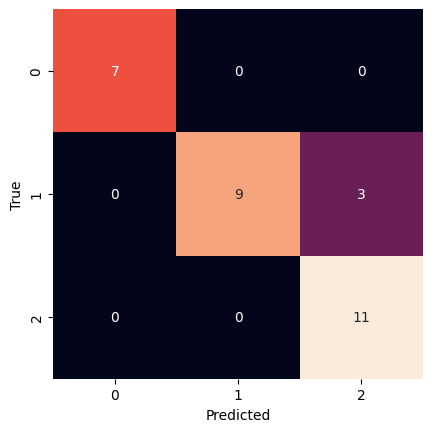

In [14]:
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn import metrics

class MultinomialNaiveBayes:
    def __init__(self):
        '''
        Initializes the naive bayes classifier instance
        '''
        self.class_probabilities = {}
        self.feature_probabilities = {}
        self.classes = None
        self.vocab_size = 0

    def fit(self, X, y):
        '''
        Fits the multinomial naive bayes classifier
        ---
        Parameters:
          X list[list]: vector of features
          y list[int]: classes to be predicted
        ---
        Returns:
          None
        '''
        # Count the number of instances and features
        num_instances, num_features = X.shape
        self.classes = np.unique(y)
        
        # Calculate class probabilities
        class_counts = np.bincount(y)
        self.class_probabilities = dict(zip(self.classes, class_counts / num_instances))

        # Calculate feature probabilities
        self.feature_probabilities = {c: {} for c in self.classes}
        self.vocab_size = num_features

        for c in self.classes:
            # Select rows for class c
            X_c = X[y == c]

            # Count feature occurrences in each class
            # Add one to prevent division by zero (Laplace smoothing)
            feature_counts = np.sum(X_c, axis=0) + 1 
            total_count = np.sum(feature_counts)

            # Calculate probabilities
            self.feature_probabilities[c] = feature_counts / total_count

    def predict(self, X):
        '''
        Predicts the classes from vectors of features using Multinomial Naive Bayes 
        ---
        Parameters:
          X list[list]: classes transformed to model readable format
        ---
        Returns:
          y list[int]: predictions made from the model and given feature vector
        '''
        predictions = []

        for x in X:
            class_scores = {}

            for c in self.classes:
                # Start with the log of the class probability
                class_score = np.log(self.class_probabilities[c])

                # Add log of feature probabilities
                for feature_index in range(self.vocab_size):
                    class_score += x[feature_index] * np.log(self.feature_probabilities[c][feature_index])
                
                class_scores[c] = class_score
            
            # Select the class with the highest score
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)

        return np.array(predictions)

# Load iris dataset
X, y = load_iris(return_X_y=True)
# Split dataset to train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the classifier
mnb = MultinomialNaiveBayes()
# Fit the classifier
mnb.fit(X_train, y_train)
# Predict the test set
pred = mnb.predict(X_test)

# Plot the confusion matrix
confusion_mat = metrics.confusion_matrix(y_test, pred)
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As shown on the confusion matrix above, the algorithm seems to be working correctly.

In [15]:
from collections import Counter
import math


def tf(t, d):
    """
    Term frequency calculation
    ---
    Input:
      t (string): term for which to calculate tf
      d (string): document
    ---
    Output:
      tf score (float): term frequency for term t in document d
    """

    freq = Counter(d.split()).get(t, 0)
    d_len = len(d.split())
    
    return freq / d_len


def idf(t, c):
    """
    Inverse document frequency
    ---
    Input:
      t (string): term for which to calculate idf
      c (list[string]): corpus
    ---
    Output:
      idf score (float)
    """
    # Number of documents in corpus
    N = len(c)
    # Number of documents with term t
    k = sum([1 if t in d.split() else 0 for d in c])

    # add 1 to prevent divisino by zero
    return math.log((N + 1) / (k + 1), math.e) + 1


def tfidf(c):
    """
    Tf-idf vectorization
    ---
    Input:
      c (list[string]): corpus with all documents for the corpus
    Output:
      tf-idf scores (list[float]): tf-idf score for each word in the corpus
    """
    # Store scores for each document
    _tfidf = []
    # Get all terms in document
    terms = sorted(list(set((" ".join(c)).split())))
    idfs = {t: idf(t, c) for t in terms}

    # For each document calculate tf-idf
    for d in c:
        tfidf_d = []
        for t in terms:
            tfidf_d.append(tf(t, d) * idfs[t])
        _tfidf.append(tfidf_d)

    # Apply Euclidian norm
    _tfidf = np.array(_tfidf) 
    _tfidf /= ((_tfidf**2).sum(1, keepdims=True))**(1/2)

    return _tfidf 

In [16]:
corpus = ["doo be doo", "al do be doo", "all wee doo be da"]

from sklearn.feature_extraction.text import TfidfVectorizer

# Make sure the vectorizer is implemented correctly
vectorizer = TfidfVectorizer()
assert np.allclose(vectorizer.fit_transform(corpus).toarray(), tfidf(corpus))

# Training

For training, I will use the sklearn's implementation of the Naive Bayes classifier and vectorizer, because their implementation is more efficient and robust.

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

import seaborn as sns

# Define the variables for the classification
y = df['from'].values
# Use the texts and all additional features
X = df[['text'] + additional_features].values

# Vectorizing the texts
vectorizer = TfidfVectorizer()
# Combining the vectorized texts with additional features
X = np.c_[vectorizer.fit_transform(X[:, 0]).toarray(), X[:, 1:]]

# Split data into the training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

# Create the Naive Bayes classifier
clf = MultinomialNB()

# Define hyperparameter for grid search
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

# Define the grid search for hyperparameter tuning
grid = GridSearchCV(clf, param_grid=params, cv=6, refit=True)

# Find the best parameters for the model
clf = grid.fit(X_train, y_train)

In [27]:
# Run the classifier with the hyperparameters on test set
pred = clf.predict(X_test)
# Create confusion matrix
confusion_mat = metrics.confusion_matrix(y_test, pred)

# Results

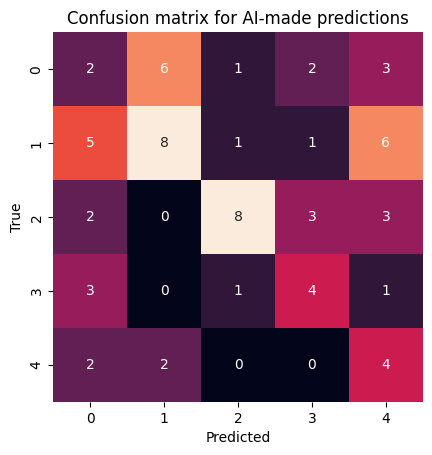

Mean accuracy = 0.38
F1 score for the predictions = [0.14285714 0.43243243 0.59259259 0.42105263 0.32      ]


In [28]:
# Plot confusion matrix
plt.title("Confusion matrix for AI-made predictions")
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Mean accuracy = {clf.score(X_test, y_test):.2f}")
print(f"F1 score for the predictions = {metrics.f1_score(y_test, pred, average=None)}")

The model seems to be doing quite good for 3 out of 5 people. It recognizes them roughly half the time. To get a better idea of how the model performs compared to a human, I built a website where the people from the group chat were guessing who the author of a text was. Below, I attached a screenshot with names taken out for privacy.

![app.png](app.png)

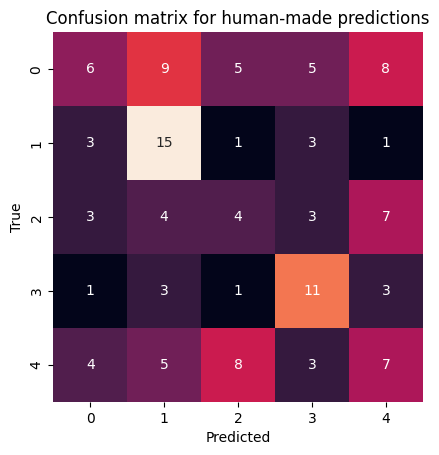

Mean accuracy = 0.35
F1 score for the predictions = [0.24       0.50847458 0.2        0.5        0.26415094]


In [20]:
import json
import pandas as pd

# Open file with data
with open('human.json', 'r') as f:
    # Read data with json module
    data = json.load(f)

# Create a dataframe based on the data
human_df = pd.DataFrame(data)

# Print the first 5 examples
human_df.head()

y_pred = human_df['predicted']
y = human_df["actual"]

# Create confusion matrix for the human predictions
confusion_mat = metrics.confusion_matrix(y, y_pred)
# Plot confusion matrix
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for human-made predictions")
plt.show()

print(f"Mean accuracy = {(y - y_pred == 0).sum()/len(y):.2f}")
print(f"F1 score for the predictions = {metrics.f1_score(y, y_pred, average=None)}")

As we can see, the AI does a pretty good job at predicting the sender, even compared to humans. The mean accuracy can be even better at around 38%, while the human performance is at around 35%. However, they are both quite low—slightly above a random choice, which would lead to 20% accuracy. Therefore, it might suggest that the task is quite hard. To get a better performance, I would probably need to gather more data and use more sophisticated techniques, such as transformer-based encoder neural networks.

# Executive Summary

In this work, I wanted to find out how well the ML model can predict who the sender of a message is. I gathered data from a group chat using the `telethon` module. I filtered it out of any links, empty messages, and stop words. I used the lemmatization technique to normalize words so that their semantical meaning is better understood by the model. I created features using the data, for example, an indication of whether the text starts with a capital letter and the number of digits and punctuation signs in the text. I trained the Naive Bayes classifier to classifier and achieved 38% accuracy, which is comparable to human-level performance.

# References

6.2. Feature extraction. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/feature_extraction.html#feature-extraction

Harder, H. de. (2022, November 5). An easy example explaining Naive Bayes. Medium. https://hennie-de-harder.medium.com/an-easy-example-explaining-naive-bayes-3f706d683625

Scikit learn. (2018). sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.20.3 documentation. Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

scikit-learn. (2019a). sklearn.metrics.f1_score — scikit-learn 0.21.2 documentation. Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

scikit-learn. (2019b). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 documentation. Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

what is the “learning” that takes place in Naive Bayes? (n.d.). Cross Validated. Retrieved February 18, 2024, from https://stats.stackexchange.com/questions/272493/what-is-the-learning-that-takes-place-in-naive-bayes

Wikipedia Contributors. (2019, June 17). Naive Bayes classifier. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Naive_Bayes_classifier
Wikipedia Contributors. (2023, December 31). tf–idf. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Definition

WordNet | A Lexical Database for English. (2019). Princeton.edu. https://wordnet.princeton.edu